# Stratification in deep ocean
Using best current case of tides and surface flux tuning:
* QCORRECT in summer everywhere, QCORRECT in winter north of 55 S
* QSOF Tf restriction
* SCORRECT all year with TNUDGE 30 days
* SSOF Tf salt input restriction
* tidal mask on shelf smooth transition
## Annual mean salt and temperature longitiude transsects compared against SOSE

In [2]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr
import os
import sys
import numpy as np

src_path = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_path)
# import my functions
import features.make_roms_ds as roms_ds

import features.make_sose_ds as sose_ds

In [4]:
#load roms_data
#rds_path = os.path.join(os.environ.get('rawdir'),'waom10_TNUDGE_3','ocean_avg_0005.nc')
rds_path = os.path.join(os.environ.get('rawdir'),'waom10_v2.0_small','ocean_avg_spinUp_0006.nc')
rds = roms_ds.make_roms_ds(rds_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [5]:
#load sose_data
sds = sose_ds.make_TS_ds(records=np.arange(0,12))

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [8]:
#%%writefile ../../src/visualization/compare_tracer.py
#define function that generates a sose vs roms longitude transsect as monthly widget or annual meandefine function that generates a sose vs roms longitude transsect as monthly widget or annual mean
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm
from ipywidgets import interact

def plot_lont(sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True,month=None):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    print('lookup nearest neighbors from sose')
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,:,ind]
    rsalt_tr = rsalt_flat[:,:,ind]
    x=rtemp_tr[0].lat_rho.fillna(0).values
    y=rtemp_tr[0].depth.fillna(0).values
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('generate widget including sose plotting')
    plt.close()
    
    if mean==False:
        def plot(month):
            fig,axes = plt.subplots(2,2,figsize=(15,12))
            (ax1,ax2,ax3,ax4) = axes.flatten()

            sds.temperature.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            ax1.set_title('SOSE')
            sds.salinity.sel(longitude=slon,latitude=lats,method='nearest')[month].plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline)
            ax3.set_title('SOSE')

            temp_plt = ax2.pcolormesh(x,y,rtemp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax2,label='temperature')
            ax2.set_title('ROMS')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')

            salt_plt = ax4.pcolormesh(x,y,rsalt_val[month],vmin=smin,vmax=smax,cmap=ocm.haline)
            plt.colorbar(salt_plt,ax=ax4,label='salinity')
            ax4.set_title('ROMS')
            ax4.set_xlabel('latitude')
            ax4.set_ylabel('depth')

            if max_depth != None:
                for ax in [ax1,ax2,ax3,ax4]:
                    ax.set_ylim([-max_depth,0])

            plt.show()

        interact(plot,month=(0,11))
        
    elif mean == True:
        
        fig,axes = plt.subplots(2,2,figsize=(15,12))
        (ax1,ax2,ax3,ax4) = axes.flatten()

        sds.temperature.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax1,x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal)
        ax1.set_title('SOSE')
        sds.salinity.sel(longitude=slon,latitude=lats,method='nearest').mean('time').plot(ax=ax3,x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline)
        ax3.set_title('SOSE')

        temp_plt = ax2.pcolormesh(x,y,np.mean(rtemp_val,axis=0),vmin=tmin,vmax=tmax,cmap=ocm.thermal)
        plt.colorbar(temp_plt,ax=ax2,label='temperature')
        ax2.set_title('ROMS')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        salt_plt = ax4.pcolormesh(x,y,np.mean(rsalt_val,axis=0),vmin=smin,vmax=smax,cmap=ocm.haline)
        plt.colorbar(salt_plt,ax=ax4,label='salinity')
        ax4.set_title('ROMS')
        ax4.set_xlabel('latitude')
        ax4.set_ylabel('depth')
        
        if max_depth != None:
            for ax in [ax1,ax2,ax3,ax4]:
                ax.set_ylim([-max_depth,0])

        plt.show()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


### Weddell sea at longitude 45 deg W

In [9]:
plot_lont(sds,rds,-45,np.arange(-80,-45),tmin=-1.9,tmax=2.4,smin=34.3,smax=34.75,max_depth=4000,mean=True)

lookup nearest neighbors from roms


AttributeError: 'DataArray' object has no attribute 'lat_rho'

### Ross sea at longitude 180

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
generate widget including sose plotting


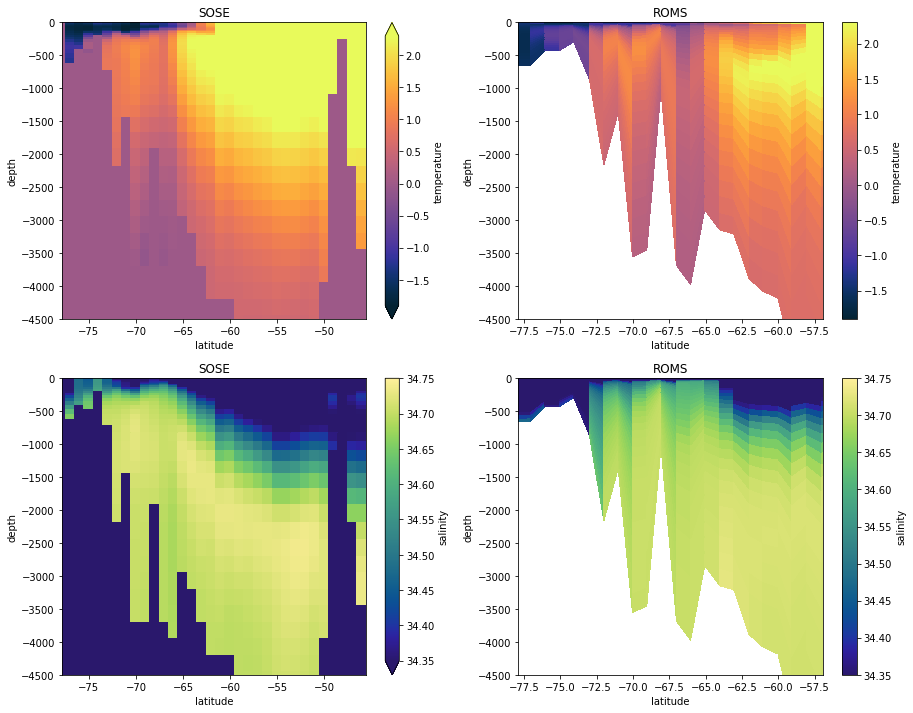

In [7]:
plot_lont(sds,rds,180,np.arange(-89,-45),tmin=-1.9,tmax=2.3,smin=34.35,smax=34.75,max_depth=4500,mean=True)

### Bellinghausen Sea and Drake Passage at longitude 75 W

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
generate widget including sose plotting


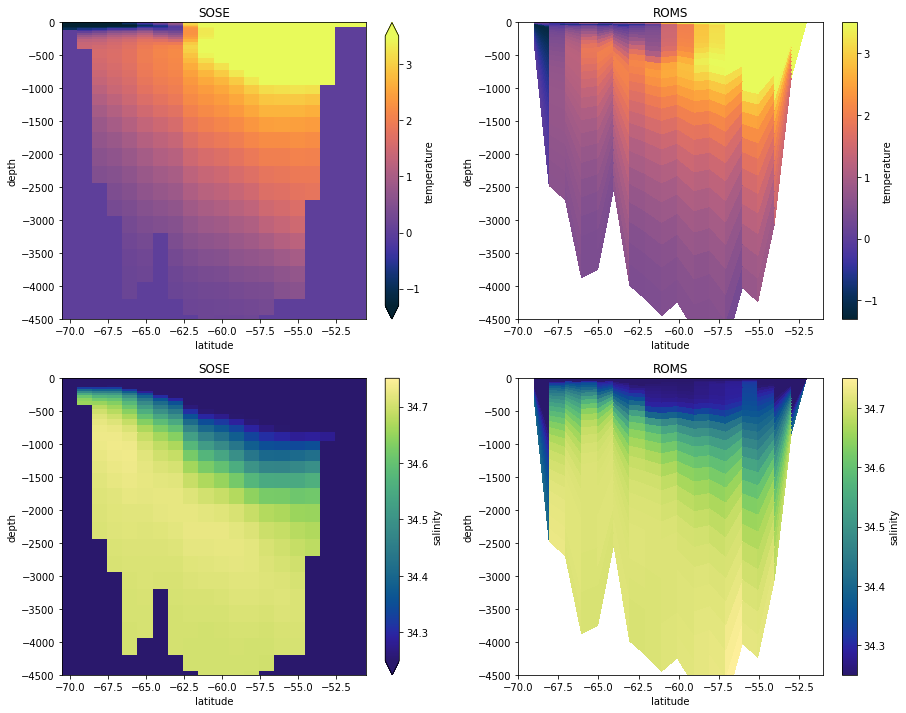

In [8]:
plot_lont(sds,rds,-75,np.arange(-70,-50),tmin=-1.3,tmax=3.5,smin=34.25,smax=34.75,max_depth=4500)

### Davis sea longitude 70 deg E

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
generate widget including sose plotting


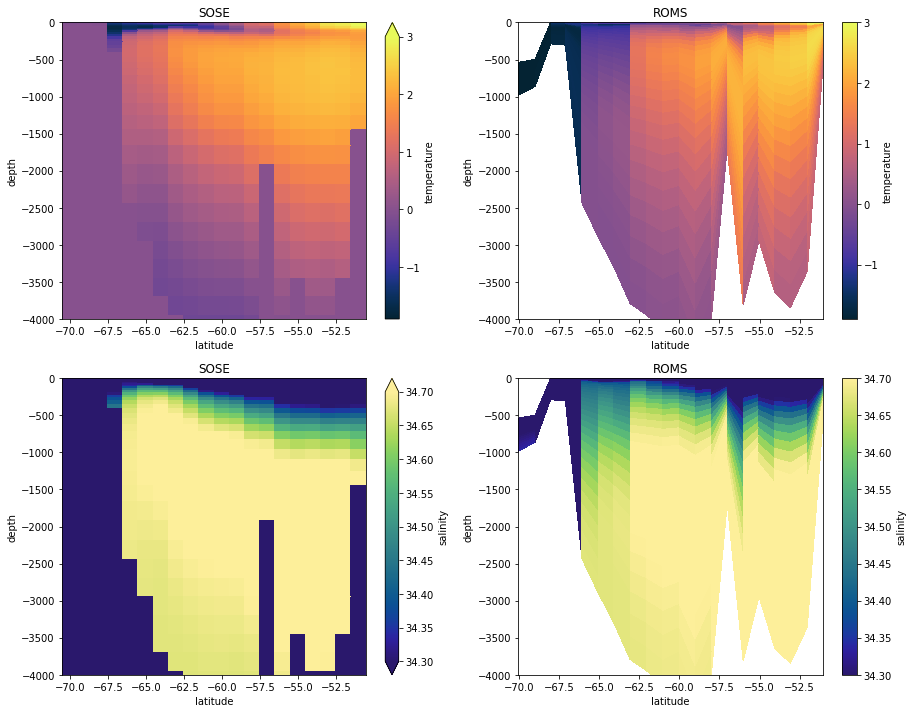

In [9]:
plot_lont(sds,rds,70,np.arange(-70,-50),tmin=-1.9,tmax=3,smin=34.3,smax=34.7,max_depth=4000)

## On shelf stratification
### Annual mean transsects along constant roms coordinates compared against SOSE

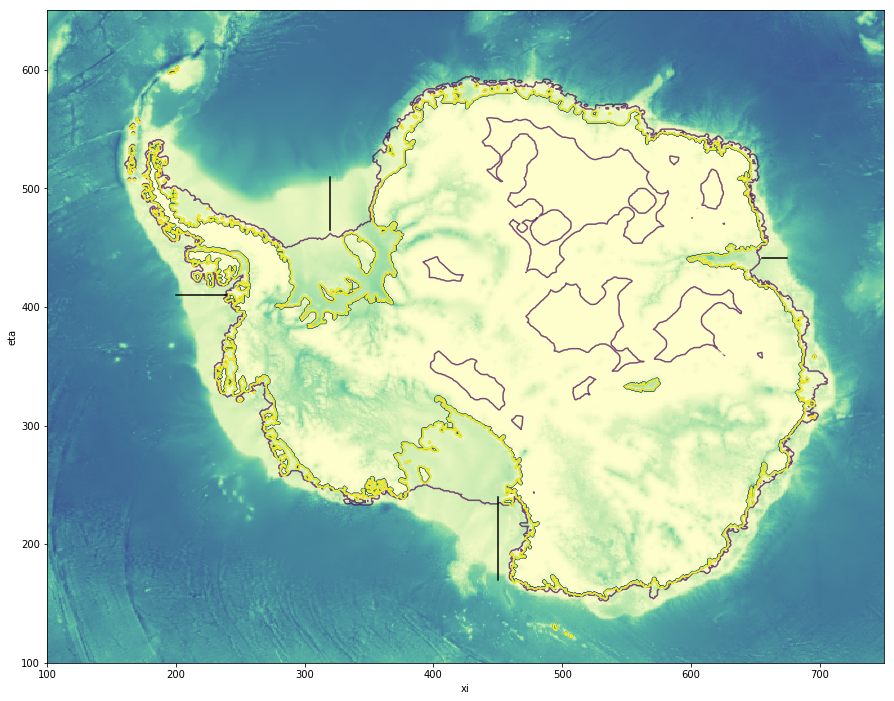

In [10]:
# defining the transsects and plot them over bathy and ice shelf front
plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=ocm.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
davis=[655,441,675,441,"amery"]
ross=[450,170,450,240,"ross"]
weddell=[320,465,320,510,"weddel"]
amundsen=[200,410,240,410,"bellinghausen"]

for line in [davis,ross,weddell,amundsen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

plt.xlim((100,750))
plt.ylim((100,650))
plt.show()

In [2]:
%%writefile -a ../../src/visualization/compare_tracer.py



### define the plotting function
def compare_onshore(rds,sds,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    

    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))

    x = rds_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    lons = rds_tr.lon_rho.to_masked_array().squeeze()
    lons[lons<0]+=360.0
    lats = rds_tr.lat_rho.to_masked_array().squeeze()
    
    lon_da = xr.DataArray(lons,dims='latitude')
    lat_da = xr.DataArray(lats,dims='latitude')
    
    print('calculate mean')
    temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
    salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()
    
    print('plot')
    plt.close()
    
    fig,axes = plt.subplots(2,2,figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    
    temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    plt.colorbar(temp_plt,ax=ax1,label='Temperature in deg C')
    ax1.set_title('ROMS')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')

    sds.temperature.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax2,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax2.set_title('SOSE')

    salt_plt = ax3.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
    plt.colorbar(salt_plt,ax=ax3,label='Salinity in PSU')
    ax3.set_title('ROMS')
    ax3.set_xlabel('latitude')
    ax3.set_ylabel('depth')

    sds.salinity.sel(longitude=lon_da,latitude=lat_da,method='nearest').mean('time').plot(ax=ax4,vmin=smin,vmax=smax,cmap=ocm.haline)
    ax4.set_title('SOSE')

    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    
    plt.show()        

Appending to ../../src/visualization/compare_tracer.py


### Davis sea

define slice
calculate mean
plot


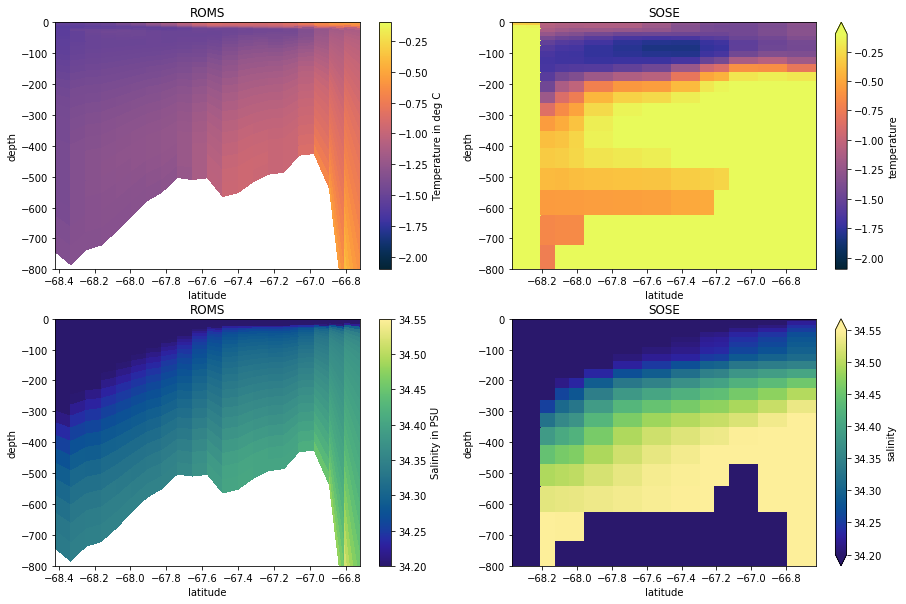

In [12]:
compare_onshore(rds,sds,davis,tmin=-2.1,tmax=-0.1,smin=34.2,smax=34.55,max_depth=800)

### Weddell Sea

define slice
calculate mean
plot


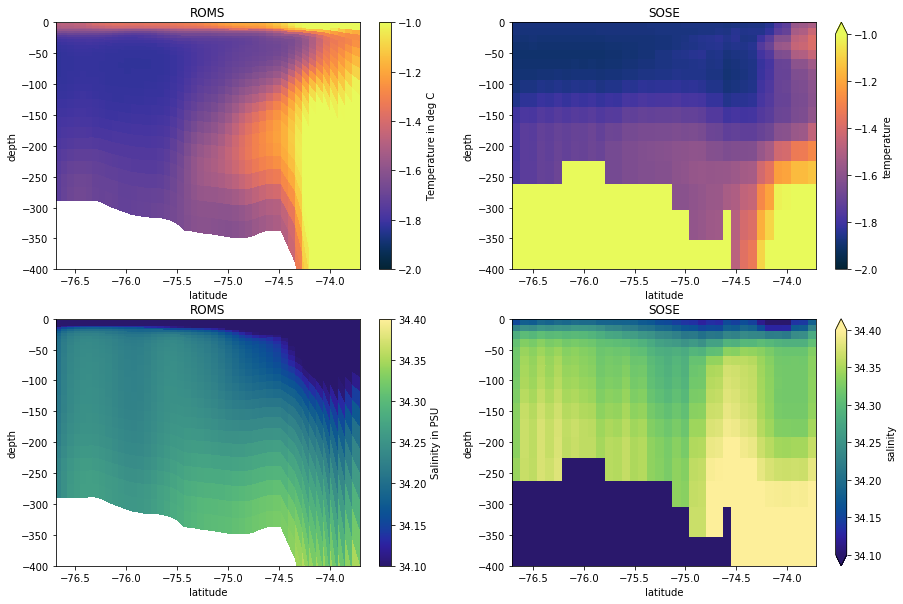

In [13]:
compare_onshore(rds,sds,weddell,tmin=-2.0,tmax=-1.0,smin=34.1,smax=34.4,max_depth=400)

### Amundsen sea

define slice
calculate mean
plot


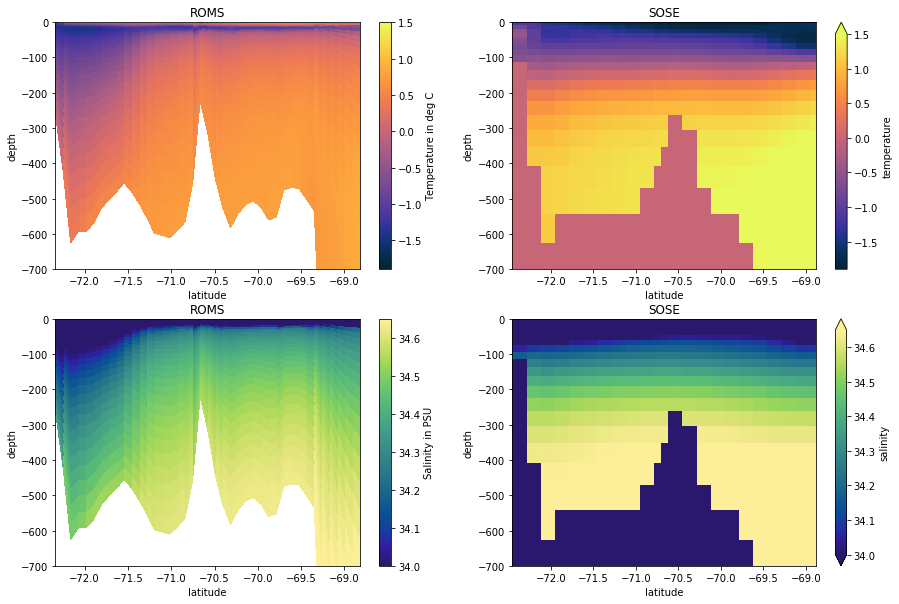

In [14]:
compare_onshore(rds,sds,amundsen,tmin=-1.9,tmax=1.5,smin=34.0,smax=34.65,max_depth=700)

### Ross sea

define slice
calculate mean
plot


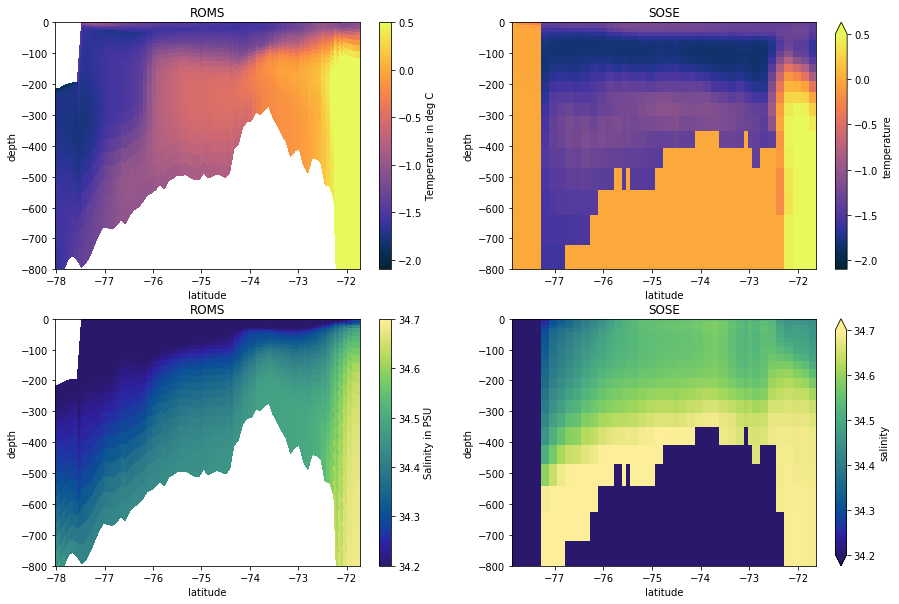

In [15]:
compare_onshore(rds,sds,ross,tmin=-2.1,tmax=0.5,smin=34.2,smax=34.7,max_depth=800)

# Under Ice shelf frontal zone
### Monthly averages ROMS only

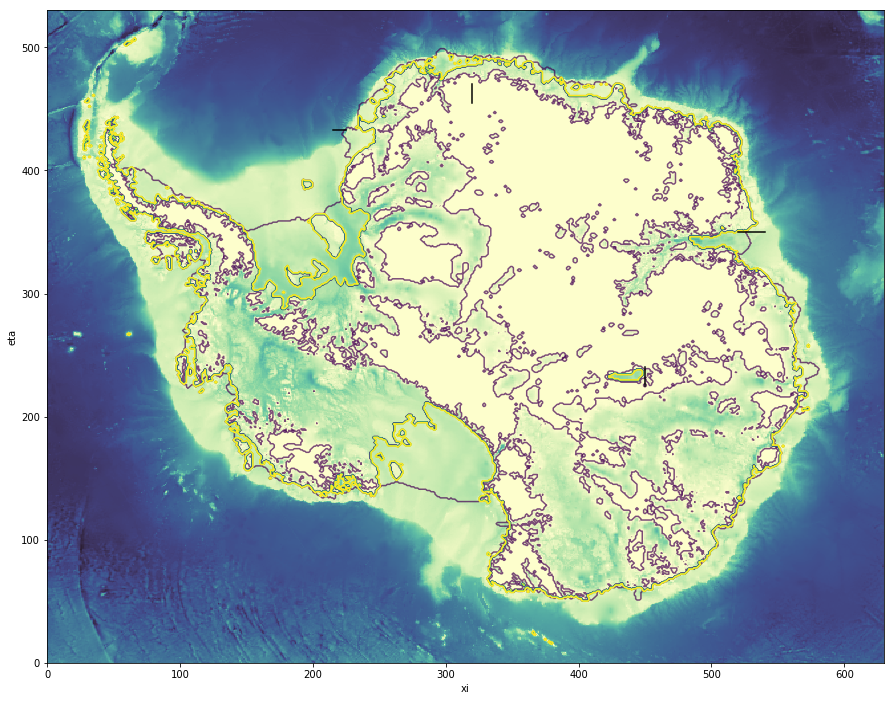

In [32]:
### defining the transsects and plotting them on top of bathy and ice front
plt.close()
fig = plt.figure(figsize=(15,12))
plt.pcolormesh(rds.h,cmap=ocm.deep)
plt.contour(rds.zice,[-0.01],alpha=0.7)
plt.contour(rds.mask_rho)
plt.xlabel('xi')
plt.ylabel('eta')
#linescodeline = [xi_min,eta_min,xi_max,eta_max]
#amery=[650,447,660,447,"amery"]
amery=[520,350,540,350,"amery"]
#ross=[450,225,450,240,"ross"]
#weddell=[320,455,320,470,"weddel"]
#bellinghausen=[215,433,225,433,"bellinghausen"]

for line in [amery,ross,weddell,bellinghausen]:
    plt.plot((line[0],line[2]),(line[1],line[3]),"k-")

#plt.xlim((100,750))
#plt.ylim((100,650))
plt.show()

In [22]:
#%%writefile -a ../../src/visualization/compare_tracer.py


### define the plotting routine
def plot_cavity(rds,grd,grid_coord,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,mean=True):            

    print('define slice')
    [xi_min,eta_min,xi_max,eta_max,loc] = grid_coord

    plt.close()

    grd_tr = grd.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))
    rds_tr = rds.isel(eta_rho=slice(eta_min,eta_max+1),xi_rho=slice(xi_min,xi_max+1))
    
    x = grd_tr.lat_rho.values.squeeze()
    y = rds_tr.depth[0].values.squeeze()
    
    y[np.isnan(y)]=0.0
    
    if mean == True:
        
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))
        
        print('calculate mean')
        temp_val = rds_tr.temp.mean('ocean_time').to_masked_array().squeeze()
        salt_val = rds_tr.salt.mean('ocean_time').to_masked_array().squeeze()

        print('plot')
        temp_plt = ax1.pcolormesh(x,y,temp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
        plt.colorbar(temp_plt,ax=ax1,label='deg C')
        ax1.set_title('Temperature')
        ax1.set_ylabel('depth')

        salt_plt = ax2.pcolormesh(x,y,salt_val,vmin=smin,vmax=smax,cmap =ocm.haline)
        plt.colorbar(salt_plt,ax=ax2,label='PSU')
        ax2.set_title('Salinity')
        ax2.set_xlabel('latitude')
        ax2.set_ylabel('depth')

        if max_depth != None:
            for ax in [ax1,ax2]:
                ax.set_ylim([-max_depth,0])
        
        plt.show()
        
    elif mean == False:
        
        print('set up widget')
        def widget(month):
            
            fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(15,10))

            temp_val = rds_tr.temp.to_masked_array().squeeze()
            salt_val = rds_tr.salt.to_masked_array().squeeze()

            temp_plt = ax1.pcolormesh(x,y,temp_val[month],vmin=tmin,vmax=tmax,cmap=ocm.thermal)
            plt.colorbar(temp_plt,ax=ax1,label='deg C')
            ax1.set_title('Temperature')
            ax1.set_ylabel('depth')

            salt_plt = ax2.pcolormesh(x,y,salt_val[month],vmin=smin,vmax=smax,cmap =ocm.haline)
            plt.colorbar(salt_plt,ax=ax2,label='PSU')
            ax2.set_title('Salinity')
            ax2.set_xlabel('latitude')
            ax2.set_ylabel('depth')
            
            if max_depth != None:
                for ax in [ax1,ax2]:
                    ax.set_ylim([-max_depth,0])
            
            plt.show()
            
        interact(widget,month=(0,11))

### Amery ice shelf

In [24]:
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grd = xr.open_dataset(grid_path)

In [33]:
plot_cavity(rds,grd,amery,tmin=-1.95,tmax=-1.5,smin=34.2,smax=34.35,mean=False,max_depth=800)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Ronne Flichner ice shelf

In [19]:
plot_cavity(rds,weddell,tmin=-2.0,tmax=-1.5,smin=34.2,smax=34.35,mean=False,max_depth=400)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Ross ice shelf

In [20]:
plot_cavity(rds,ross,tmin=-1.90,tmax=-1.6,smin=34.25,smax=34.45,mean=False,max_depth=900)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))

### Wilkins ice shelf

In [21]:
plot_cavity(rds,bellinghausen,tmin=-1.95,tmax=-0.6,smin=33.6,smax=34.3,mean=False,max_depth=250)

define slice
set up widget


interactive(children=(IntSlider(value=5, description='month', max=11), Output()), _dom_classes=('widget-interact',))